In [1]:
import new_adventure as na
import new_adventure.derivative_free_estimation as dfe
import numpy as np
import matplotlib.pyplot as plt
import time
from jax import random as jrandom
import jax.numpy as jnp
import jax 
import pandas as pd
from tqdm import tqdm 

%load_ext autoreload
%autoreload 2


%matplotlib inline
plt.rcParams['figure.figsize'] = [14,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 25})


/Users/daniellengyel/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [99]:
np.random.seed(10)
dim = 100
num_barriers = dim * 2
dirs = np.random.normal(size=(num_barriers, dim)) # sample gaussian and normalize 
ws = dirs/np.linalg.norm(dirs, axis=1).reshape(-1, 1)
bs = np.ones(num_barriers)

jrandom_key = jrandom.PRNGKey(0)

x_0 = np.zeros(dim)

barrier = na.Barriers.LogPolytopeBarrier(ws, bs)

F = barrier 

In [71]:
# We get 2E2, 2E1 without control variates, 2E1 with mean control variate, 2E1 with heuristic control variate

def beta_2E1_tests(F, x_0, alpha, N, jrandom_key, control_variate=True, heuristic_CV=True):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    sample_points, R = dfe.jax_hit_run(x_0, F, x_0.shape[0], N, alpha, subkey)  
    if control_variate: 
        ru = sample_points - jnp.mean(sample_points, axis=0)
    else:
        ru = sample_points - x_0
    jrandom_key, subkey = jrandom.split(jrandom_key)
    out_grads = F.f1(sample_points, subkey)
    g_ru = out_grads.T.dot(ru)/float(N)
    if heuristic_CV:
        cov = ru.T.dot(ru) / N
        return g_ru.dot(jnp.linalg.inv(cov))
    
    cov = dfe.beta_covariance(x_0.shape[0], R, alpha) # jnp.cov(sample_points.T)
    return g_ru * 1/cov


0.17024839
0.6162017
0.74536204
0.8187596
0.86884487
0.90629363
0.93588305
0.9601508
0.9806174
0.9982165


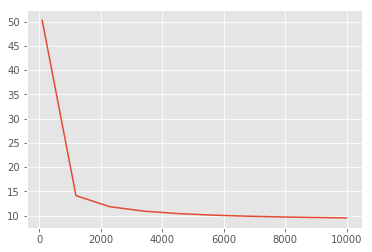

In [92]:
rr = []
for b in jnp.linspace(100, 10000, 10):
    rr.append(jnp.linalg.norm(dfe.FD_2FD1(F, x_0, b, dim, subkey) - true_hess))
plt.plot(jnp.linspace(100, 10000, 10), rr)

# Histogram of Distance to true Hessian 

In [113]:
alpha = 5
N = 5000

num_trials = 10

res_dict = {"2E1": [], "2E1_meanCV": [], "2E1_covCV": [], "2E1_meanCV_covCV": [], "2FD1": []}

true_hess = F.f2(x_0.reshape(1, -1))[0]

err_bound = 1e4


import time
for _ in range(num_trials):
    jrandom_key, subkey = jrandom.split(jrandom_key)
#     res_dict["2E1"].append(jnp.linalg.norm(beta_2E1_tests(F, x_0, alpha, N, subkey, control_variate=False, heuristic_CV=False) - true_hess))
#     res_dict["2E1_meanCV"].append(jnp.linalg.norm(beta_2E1_tests(F, x_0, alpha, N, subkey, control_variate=True, heuristic_CV=False) - true_hess))
#     res_dict["2E1_covCV"].append(jnp.linalg.norm(beta_2E1_tests(F, x_0, alpha, N, subkey, control_variate=False, heuristic_CV=True) - true_hess))
    res_dict["2E1_meanCV_covCV"].append(jnp.linalg.norm(beta_2E1_tests(F, x_0, alpha, N, subkey, control_variate=True, heuristic_CV=True) - true_hess))
    res_dict["2FD1"].append(jnp.linalg.norm(dfe.FD_2FD1(F, x_0, err_bound, dim, subkey) - true_hess))


2E1


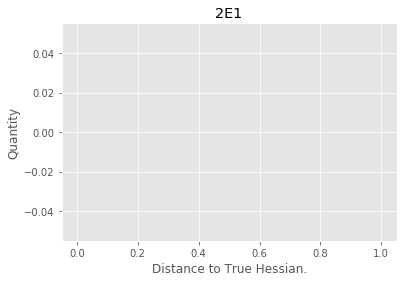

2E1_meanCV


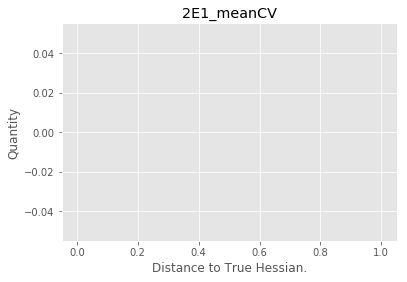

2E1_covCV


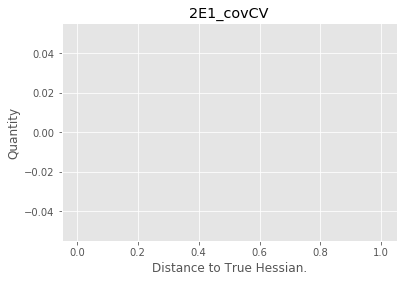

2E1_meanCV_covCV


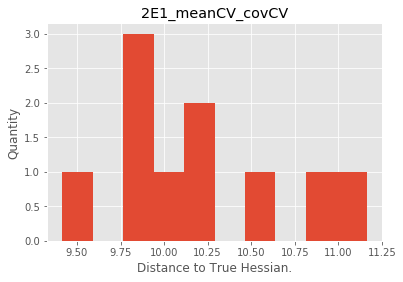

2FD1


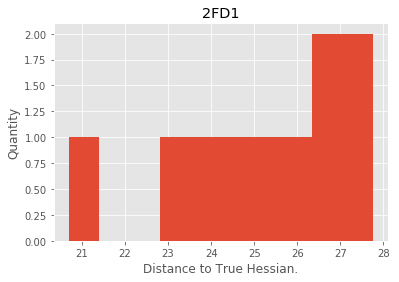

In [114]:
for k in res_dict:
    print(k)
    plt.hist(res_dict[k])
    plt.xlabel("Distance to True Hessian.")
    plt.ylabel("Quantity")
    plt.title(k)
    plt.savefig("./figs/{}".format(k))
    plt.show()

# Multilevel Variance 